In [2]:
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import pandas as pd
from scipy.stats import entropy
import math
import keras

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

In [4]:
df = pd.read_csv("./data/icici_04-18_clean.csv")
df = df['Close'][0:-1].values
print(df.shape)

KeyError: 'Close'

In [16]:
# no of days in one row:
num_days = 7
stock_prices = np.reshape(df, (-1,num_days))
print(stock_prices.shape)
a = stock_prices
Feature_array = []
for row in range(0,a.shape[0]):
    mean = np.mean(a[row])
    f = np.array([mean])
    skewness = skew(a[row], axis=0, bias=True)
    f = np.append(f, skewness)
    kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
    f= np.append(f, kurt)
    variance = np.var(a[row])
    f = np.append(f, variance)
    std = np.std(a[row])
    f = np.append(f, std)
    x = np.arange(0,len(a[row]),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
    f = np.append(f, slope)
    f = np.append(f, entropy1(a[row]))
    df = pd.DataFrame({'A' : a[row]})
    f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
    Feature_array.append(f)
    
Feature_array = np.asarray(Feature_array)

(78, 7)


In [17]:
x_train = Feature_array
y_train = stock_prices
final_units = stock_prices.shape[0] * stock_prices.shape[1]
# y_train = np.reshape(y_train, (final_units))

In [18]:
test_div = int(np.floor(Feature_array.shape[0] * 0.8))
val_div = int(np.floor(Feature_array.shape[0]*0.6))
x_train = Feature_array[:val_div]
x_valid = Feature_array[val_div:test_div]
x_test = Feature_array[test_div:]
y_train = stock_prices[:val_div]
y_valid = stock_prices[val_div:test_div]
y_test = stock_prices[test_div:]

In [19]:
# y_train = np.reshape(y_train, (1,240))
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(46, 8) (16, 8)
(46, 7) (16, 7)


In [21]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, input_dim = 8, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(num_days))

model.summary()

filepath="weights_best.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max')
callbacks = [checkpoint]
model.compile(loss=keras.losses.mse,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
            epochs=400,
            batch_size=16,
          validation_data = (x_valid, y_valid),
          callbacks = callbacks
         )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 177,543
Trainable params: 177,543
Non-trainable params: 0
_________________________________________________________________
Train on 46 samples, validate on 16 samples
Epoch 1/400
46/46 [==============================] - 1s 32ms/step - loss: 123.6653 - acc: 0.

# Train Accuracy and plot

Train loss: 0.051015553267105766
Train accuracy: 0.391304347826087


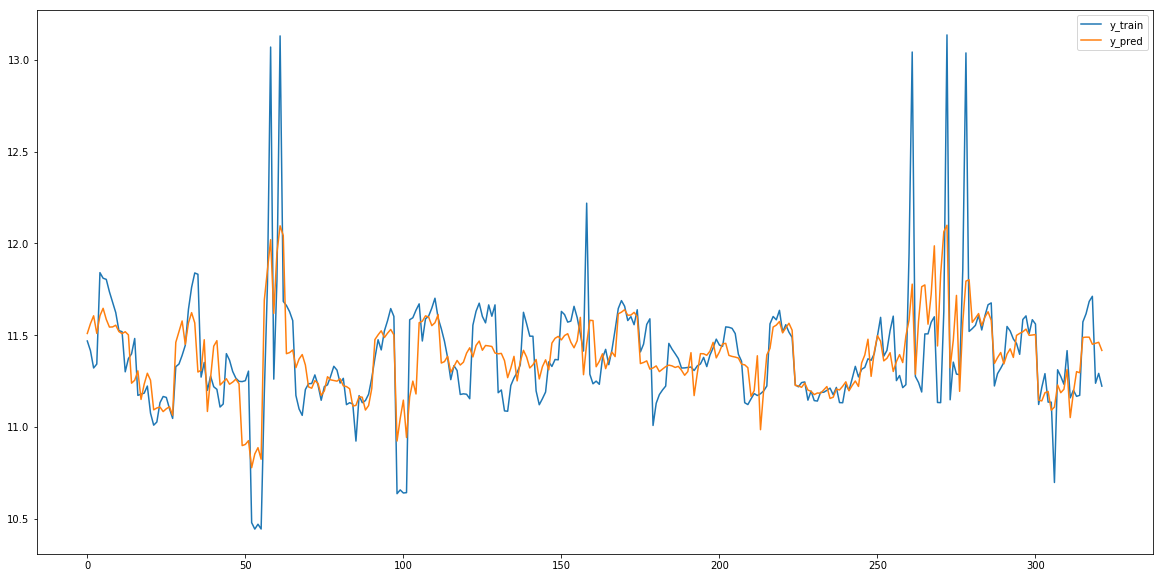

In [22]:
# Best Model
model.load_weights(filepath)
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
y_pred = model.predict(x_train)
plt.figure(figsize=(20,10))
plt.plot(y_train.ravel(), label = 'y_train')
plt.plot(y_pred.ravel(), label = 'y_pred')
plt.legend()

In [23]:
rms=np.sqrt(np.mean(np.power((y_train-y_pred),2)))
print(rms)

0.22586621032620266


# Test accuracy and plot

In [24]:
# Best Model
# model.load_weights(filepath)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(x_test)

Test loss: 0.04558529704809189
Test accuracy: 0.375


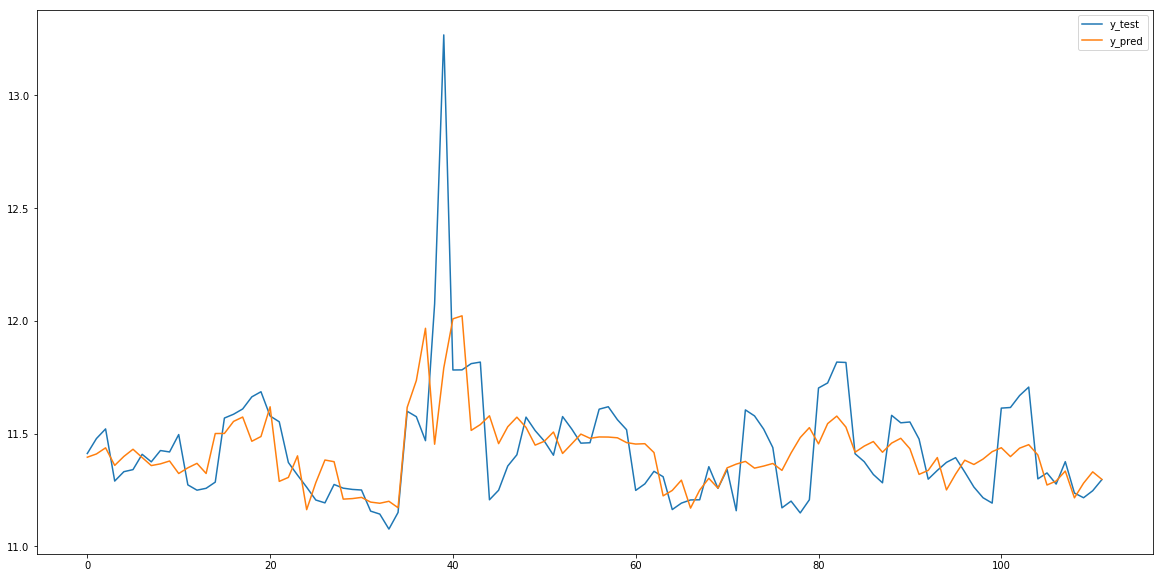

In [25]:
plt.figure(figsize=(20,10))
plt.plot(y_test.ravel(), label = 'y_test')
plt.plot(y_pred.ravel(), label = 'y_pred')
plt.legend()

In [26]:
rms=np.sqrt(np.mean(np.power((y_test-y_pred),2)))
print(rms)

0.2135071230097696
